# Match each irrigation pixel to the nearest dam around in that year
1. Change CRS to EPSG:3395 (World Mercator): Suitable for global studies, provides distance in meters.
1. Match each irrigation pixel to the nearest dam and claculate this distance

For the future: 
1. add in data on dams from other datasets? 
1. Match dams and irrigated areas to nearest river and check the distance downstream? Or just using a DEM to keep it simple? 

In [36]:
from shapely.geometry import Point
import geopandas as gpd
import os
import rasterio
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
from shapely.ops import nearest_points

data_loc = '/home/waves/data/Africa_Irrigation/Data'

In [44]:
# Load the dam datas
dam_data_path_1 = os.path.join(data_loc, 'anna', 'raw', 'dams-rev01-global-shp', 'GRanD_dams_v1_1.shp')
dam_data_1 = gpd.read_file(dam_data_path_1)

dam_data_path_2 = os.path.join(data_loc, 'Raw/globaldamsdatabase_global_coverage_november_2020.csv')
dam_data_2 = pd.read_csv(dam_data_path_2)

In [45]:
# Filter and keep only the necessary columns
dam_data_2 = dam_data_2[['YEAR', 'Long__res_', 'Lat__res_']]
dam_data_2 = dam_data_2.rename(columns={'YEAR': 'Year', 'Long__res_': 'Longitude', 'Lat__res_': 'Latitude'}) # Not sure if I should use Lat__res or Lat__hydro? Don't know the difference.

dam_data_1 = dam_data_1[['YEAR', 'LONG_DD', 'LAT_DD']]
dam_data_1 = dam_data_1.rename(columns={'YEAR': 'Year', 'LONG_DD': 'Longitude', 'LAT_DD': 'Latitude'}) # I'm not  sure what DD stands for

# Combine the two datasets
filtered_data = pd.concat([dam_data_1, dam_data_2], axis=0)

# Ensure Longitude and Latitude are treated as numeric using .loc
filtered_data.loc[:, 'Longitude'] = pd.to_numeric(filtered_data['Longitude'], errors='coerce')
filtered_data.loc[:, 'Latitude'] = pd.to_numeric(filtered_data['Latitude'], errors='coerce')

# Exclude rows where both 'Longitude' and 'Latitude' are 0
filtered_data = filtered_data[(filtered_data['Longitude'] != 0) | (filtered_data['Latitude'] != 0)].copy()

geometry = [Point(xy) for xy in zip(filtered_data['Longitude'], filtered_data['Latitude'])]
gdf_dams = gpd.GeoDataFrame(filtered_data, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

# Add a dam id
gdf_dams['Dam_ID'] = range(1, len(gdf_dams) + 1)

In [46]:
# Calculate nearest dam for each irrigation point
def calculate_distances(src_gdf, target_gdf):
    # Extract the centroids or coordinates of the irrigation points and dams
    src_points = np.array(list(src_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    # If there are no target points (dams), return an empty array
    if len(target_points) == 0:
        return np.array([])  
    
    # Create a cKDTree for the target (dam) points
    tree = cKDTree(target_points)
    
    # Query the tree for the nearest target point (dam) to each source point (irrigation point)
    distances, indices = tree.query(src_points, k=1)
    
    return distances, indices

In [58]:

def add_dam_distances(source, year, gdf_dams=gdf_dams):
    '''
    This function calculates the distance from each irrigation point to the nearest dam and adds this information to the AEI GeoDataFrame.

    It then saves the data. 
    '''
    # Load the AEI data
    print(f"Loading {source} AEI data for {year}...")
    aei_data_path = os.path.join(data_loc, 'anna', 'intermediate', 'aei', f'{source}_aei_{year}.shp')
    aei = gpd.read_file(aei_data_path)

    # Ensure that both GeoDataFrames use EPSG:3395 (World Mercator) projection
    print("Reprojecting data to EPSG:3395...")
    gdf_dams = gdf_dams.to_crs("EPSG:3395")
    aei = aei.to_crs(gdf_dams.crs)

    # Filter the dam data to only include dams whose year is less than or equal to the year of the AEI data
    print(f"Filtering dam data to remove dams built after the AEI data year ({year})...")
    dams_year = gdf_dams[~(gdf_dams['Year'] > year)]
    print(f"Removed {len(gdf_dams) - len(dams_year)} dams built after {year}.")

    # Remove empty or invalid geometries from aei (irrigation points)
    print("Removing invalid irrigation points...")
    aei_clean = aei[aei.is_valid & aei.geometry.notnull() & ~aei.geometry.is_empty]

    # Remove empty or invalid geometries from dams_year (dams)
    print("Removing invalid dams...")
    dams_year_clean = dams_year[dams_year.is_valid & dams_year.geometry.notnull() & ~dams_year.geometry.is_empty]

    # Optionally, you can check how many rows were removed
    print(f"Removed {len(aei) - len(aei_clean)} invalid irrigation points.")
    print(f"Removed {len(dams_year) - len(dams_year_clean)} invalid dams.")

    # Calculate the nearest dam for each irrigation point
    print("Calculating nearest dam for each irrigation point...")
    nearest_dam_distances = {}
    nearest_dam_indices = {}

    # Calculate the distances and nearest dam indices
    distances, indices = calculate_distances(aei_clean, dams_year_clean)
    nearest_dam_distances = distances
    nearest_dam_indices = indices

    # Add the nearest dam information to the aei GeoDataFrame
    print("Adding nearest dam information to AEI data...")
    aei_clean['distance_to_nearest_dam_(km)'] = nearest_dam_distances/1000  # Convert meters to kilometers
    aei_clean['nearest_dam_index'] = nearest_dam_indices

    # Save the data
    print("Saving AEI data with nearest dam information...")
    os.makedirs(os.path.join(data_loc, 'anna', 'intermediate', 'aei_with_dams'), exist_ok=True)
    output_path = os.path.join(data_loc, 'anna', 'intermediate', 'aei_with_dams', f'{source}_aei_{year}.shp')
    aei_clean.to_file(output_path)

    return aei_clean

In [50]:
mehta_2015 = add_dam_distances('Mehta', 2015)


Loading Mehta AEI data for 2015...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2015)...
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/545466496.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


In [51]:
mehta_2015.head()

,Longitude,Latitude,Year,AEI,index_righ,iso3,status,color_code,name,continent,region,iso_3166_1,french_sho,in_ssa,geometry,distance_to_nearest_dam,nearest_dam_index
0,28.208333,70.458333,2015,21.284599,26.0,NOR,Member State,NOR,Norway,Europe,Northern Europe,NO,Norvège,0,POINT (3140137.303 11179239.478),143386.431272,3681
1,28.208333,70.375000,2015,17.773230,NaN,None,None,None,None,None,None,None,None,None,POINT (3140137.303 11151583.627),141478.740425,3681
2,28.125000,70.291667,2015,10.713810,26.0,NOR,Member State,NOR,Norway,Europe,Northern Europe,NO,Norvège,0,POINT (3130860.679 11124040.523),135858.682888,3681
3,28.125000,70.208333,2015,1.361084,26.0,NOR,Member State,NOR,Norway,Europe,Northern Europe,NO,Norvège,0,POINT (3130860.679 11096609.196),144709.229649,3681
4,28.208333,70.208333,2015,15.540690,26.0,NOR,Member State,NOR,Norway,Europe,Northern Europe,NO,Norvège,0,POINT (3140137.303 11096609.196),153227.101832,3681


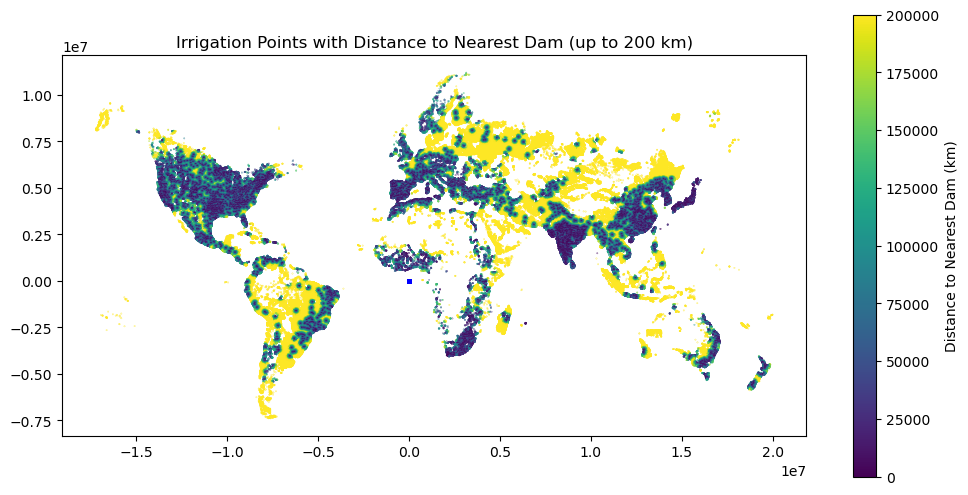

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a norm that focuses on distances up to 200 km
norm = mcolors.Normalize(vmin=0, vmax=200000)  # Anything above 200km will have the same color

# Plot the irrigation points with the distance to the nearest dam as the color
fig, ax = plt.subplots(figsize=(12, 12))
mehta_2015.plot(
    ax=ax,
    column='distance_to_nearest_dam',
    markersize=0.05,
    cmap='viridis',
    norm=norm,  # Apply the normalization
    legend=True,
    legend_kwds={
        'label': "Distance to Nearest Dam (km)",
        'shrink': 0.5  # Adjust the size of the legend
    }
)

# Plot the dams
gdf_dams.plot(ax=ax, color='blue', markersize=5, label='Dams')

# Add the title
plt.title('Irrigation Points with Distance to Nearest Dam (up to 200 km)')

# Show the plot
plt.show()


In [59]:
# Calculate the distance to the nearest dam for both "Meier" and "Mehta" data and for all years
for source in ['Meier', 'Mehta']:
    for year in range(1980, 2016, 5):
        add_dam_distances(source, year)

Loading Meier AEI data for 1980...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1980)...
Removed 2832 dams built after 1980.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 1985...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1985)...
Removed 1713 dams built after 1985.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 1990...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1990)...
Removed 988 dams built after 1990.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 1995...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1995)...
Removed 596 dams built after 1995.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 2000...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2000)...
Removed 292 dams built after 2000.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 2005...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2005)...
Removed 98 dams built after 2005.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 2010...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2010)...
Removed 31 dams built after 2010.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Meier AEI data for 2015...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2015)...
Removed 4 dams built after 2015.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 1980...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1980)...
Removed 2832 dams built after 1980.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 1985...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1985)...
Removed 1713 dams built after 1985.
Removing invalid irrigation points...
Removing invalid dams...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...
Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 1990...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1990)...
Removed 988 dams built after 1990.
Removing invalid irrigation points...
Removing invalid dams...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...
Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 1995...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (1995)...
Removed 596 dams built after 1995.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 2000...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2000)...
Removed 292 dams built after 2000.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 2005...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2005)...
Removed 98 dams built after 2005.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 2010...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2010)...
Removed 31 dams built after 2010.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)


Loading Mehta AEI data for 2015...
Reprojecting data to EPSG:3395...
Filtering dam data to remove dams built after the AEI data year (2015)...
Removed 4 dams built after 2015.
Removing invalid irrigation points...
Removing invalid dams...
Removed 0 invalid irrigation points.
Removed 1 invalid dams.
Calculating nearest dam for each irrigation point...


/home/annaboser/miniconda3/envs/irrigation/lib/python3.12/site-packages/geopandas/geoseries.py:786: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Adding nearest dam information to AEI data...
Saving AEI data with nearest dam information...


/tmp/ipykernel_3872114/812405688.py:51: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  aei_clean.to_file(output_path)
